In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [56]:
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import *
from datetime import datetime
from pyspark.ml.feature import StringIndexer

In [3]:
sqlContext = SQLContext(sc)

In [9]:
status_df = spark.read.format("com.mongodb.spark.sql.DefaultSource")\
.option("uri","mongodb://54.245.37.88:27017/bikeshare.status").load()
status_df.printSchema()

trip_df = spark.read.format("com.mongodb.spark.sql.DefaultSource")\
.option("uri","mongodb://54.245.37.88:27017/bikeshare.trip").load()
trip_df.printSchema()

station_df = spark.read.format("com.mongodb.spark.sql.DefaultSource")\
.option("uri","mongodb://54.245.37.88:27017/bikeshare.station").load()
station_df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- bikes_available: integer (nullable = true)
 |-- docks_available: integer (nullable = true)
 |-- station_id: integer (nullable = true)
 |-- time: string (nullable = true)



In [40]:
#functions to transform dataframe

def toIntSafe(num):
    try:
        return int(num)
    except ValueError:
        return None
    
def toFloatSafe(num):
    try:
        return float(num)
    except ValueError:
        return None    
    
def toTimeStampSafe(data):
    try:
        return datetime.strptime(data, "%Y/%m/%d %H:%M:%S") 
    except ValueError:
        return None
    
def time_of_day(x):
    x = toTimeStampSafe(x)
    if x:
        hour = x.hour
        if hour >= 6 and hour < 10:
            return 0
        if hour >= 10 and hour < 14:
            return 1
        if hour >= 14 and hour < 20:
            return 2
        if hour >= 20 or hour < 6:
            return 3
    else:
        return None
    
def isWeekday(x):
    x = toTimeStampSafe(x)
    if x:
        weekday = x.isoweekday()
        if weekday < 5:
            return 1
        else:
            return 0
    else:
        return None

In [41]:
timefunction = udf(lambda x: time_of_day(x))
weekfunction = udf(lambda x: isWeekday(x))

status = status_df.withColumn('bike_util', \
        ((col('docks_available') * 1.0) /(col('bikes_available') + col('docks_available'))))

status = status.select('station_id', 'bike_util', timefunction('time').alias('time_of_day'), \
                 weekfunction('time').alias('is_weekday')).cache()


In [43]:
grouped_avg = status.groupBy('station_id', 'time_of_day', 'is_weekday')\
.mean('bike_util').cache()
grouped_avg.show(5)

+----------+-----------+----------+------------------+
|station_id|time_of_day|is_weekday|    avg(bike_util)|
+----------+-----------+----------+------------------+
|        33|          3|         0|0.4708473631157447|
|        54|          1|         0|0.5734373450314982|
|        64|          1|         0| 0.483741115137601|
|         4|          0|         0|0.5106019898067203|
|        33|          0|         0|0.4721440085975422|
+----------+-----------+----------+------------------+
only showing top 5 rows



In [48]:
#join station and transformed bike usage df 
station = station_df.select('id', 'city', 'lat', 'long').withColumnRenamed('id', 'station_id').cache()
df_grouped_avg = grouped_avg.join(station, on = 'station_id').cache()
df_grouped_avg.show(5)

+----------+-----------+----------+-------------------+---+-------------+------------------+-------------------+
|station_id|time_of_day|is_weekday|     avg(bike_util)| id|         city|               lat|               long|
+----------+-----------+----------+-------------------+---+-------------+------------------+-------------------+
|        33|          3|         0|0.47084736311564057| 33|Mountain View|37.400240999999994|        -122.099076|
|        54|          1|         0| 0.5734373450314806| 54|San Francisco|         37.787152|-122.38801299999999|
|        64|          1|         0| 0.4837411151376372| 64|San Francisco|         37.782259|        -122.392738|
|         4|          0|         0| 0.5106019898067216|  4|     San Jose|         37.333988|        -121.894902|
|        33|          0|         0| 0.4721440085975496| 33|Mountain View|37.400240999999994|        -122.099076|
+----------+-----------+----------+-------------------+---+-------------+------------------+----

In [49]:
df = df_grouped_avg.toPandas()
df.head()

station_id time_of_day is_weekday  avg(bike_util)  id           city  \
0          33           3          0        0.470847  33  Mountain View   
1          54           1          0        0.573437  54  San Francisco   
2          64           1          0        0.483741  64  San Francisco   
3           4           0          0        0.510602   4       San Jose   
4          33           0          0        0.472144  33  Mountain View   

         lat        long  
0  37.400241 -122.099076  
1  37.787152 -122.388013  
2  37.782259 -122.392738  
3  37.333988 -121.894902  
4  37.400241 -122.099076

In [50]:
status.unpersist()
station.unpersist()
grouped_avg.unpersist()

DataFrame[station_id: int, time_of_day: string, is_weekday: string, avg(bike_util): double]

In [74]:
vmax = df['avg(bike_util)'].max()
vmin = df['avg(bike_util)'].min()

weekend0 = df[(df.time_of_day == '0') & (df.is_weekday == '0')]
weekend1 = df[(df.time_of_day == '1') & (df.is_weekday == '0')]
weekend2 = df[(df.time_of_day == '2') & (df.is_weekday == '0')]
weekend3 = df[(df.time_of_day == '3') & (df.is_weekday == '0')]
week0 = df[(df.time_of_day == '0') & (df.is_weekday == '1')]
week1 = df[(df.time_of_day == '1') & (df.is_weekday == '1')]
week2 = df[(df.time_of_day == '2') & (df.is_weekday == '1')]
week3 = df[(df.time_of_day == '3') & (df.is_weekday == '1')]

In [170]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import pandas as pd

def plotHeatmap(df,bbox,plot_type,fig_kwargs,bmap_kwargs,plot_kwargs):
    vmax = df['avg(bike_util)'].max()
    vmin = df['avg(bike_util)'].min()
    fig, ax = plt.subplots(**fig_kwargs)
    bmap = Basemap(bbox[0], bbox[1], bbox[2], bbox[3], ax=ax, **bmap_kwargs)
#     bmap.drawcoastlines()
    bmap.drawmapboundary()
    bmap.arcgisimage(service = 'World_Street_Map', xpixels = 5000, verbose = False)
    x, y = bmap(df['long'].values, df['lat'].values)
    if plot_type == 'scatter':
        plot = bmap.scatter(
            x, y, c=df['avg(bike_util)'].values, vmax = vmax, vmin = vmin, **plot_kwargs)
    elif plot_type == 'hexbin':
        plot = bmap.hexbin(
            x, y, C=df['avg(bike_util)'].values, vmax = vmax, vmin = vmin, **plot_kwargs)

    bmap.colorbar(plot, **cbar_kwargs)
    return bmap, fig, ax

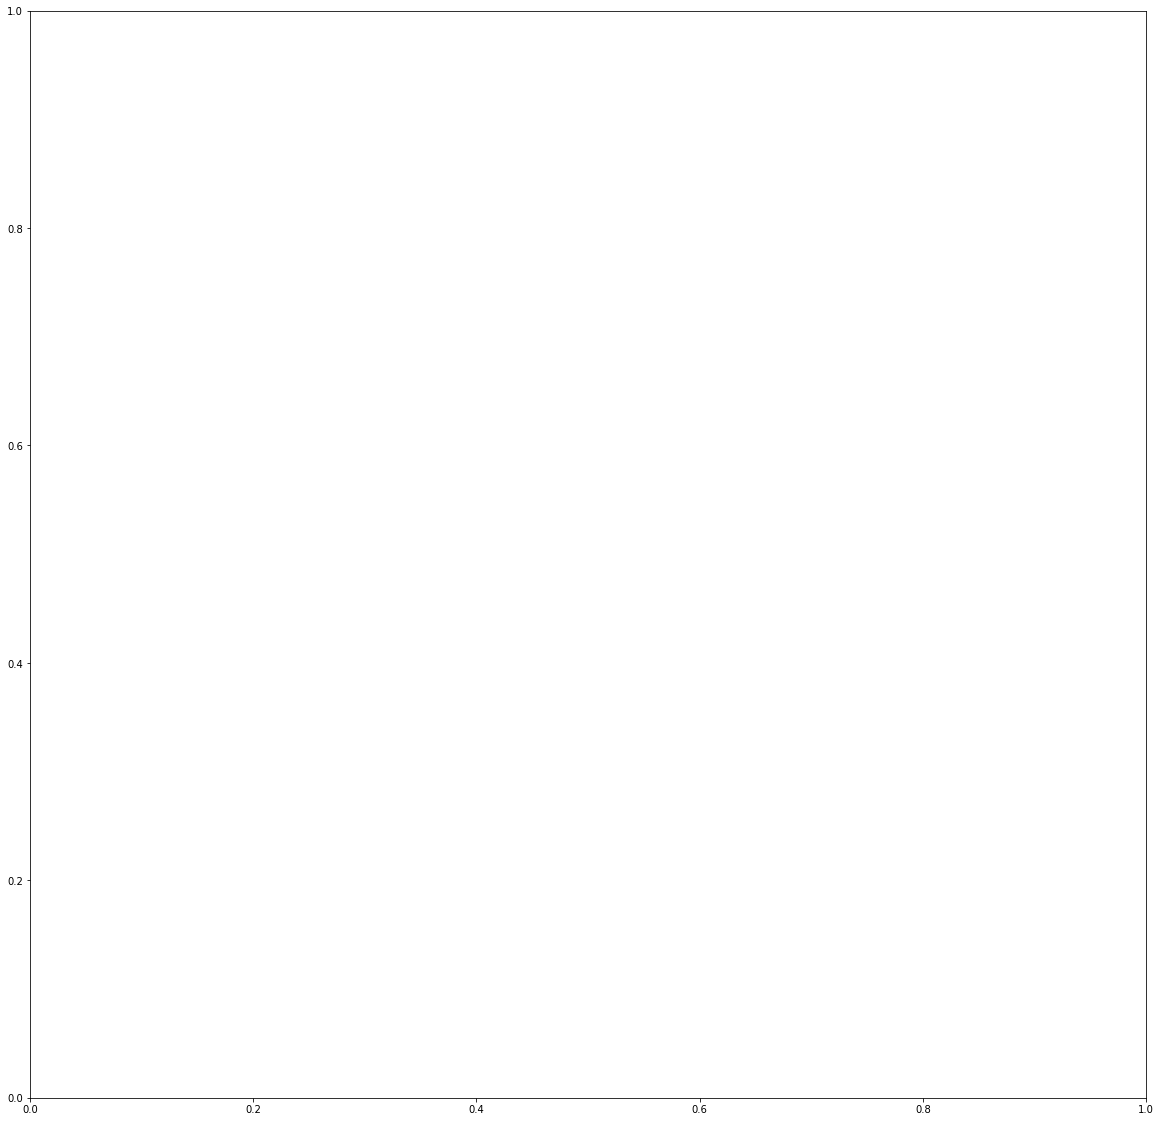

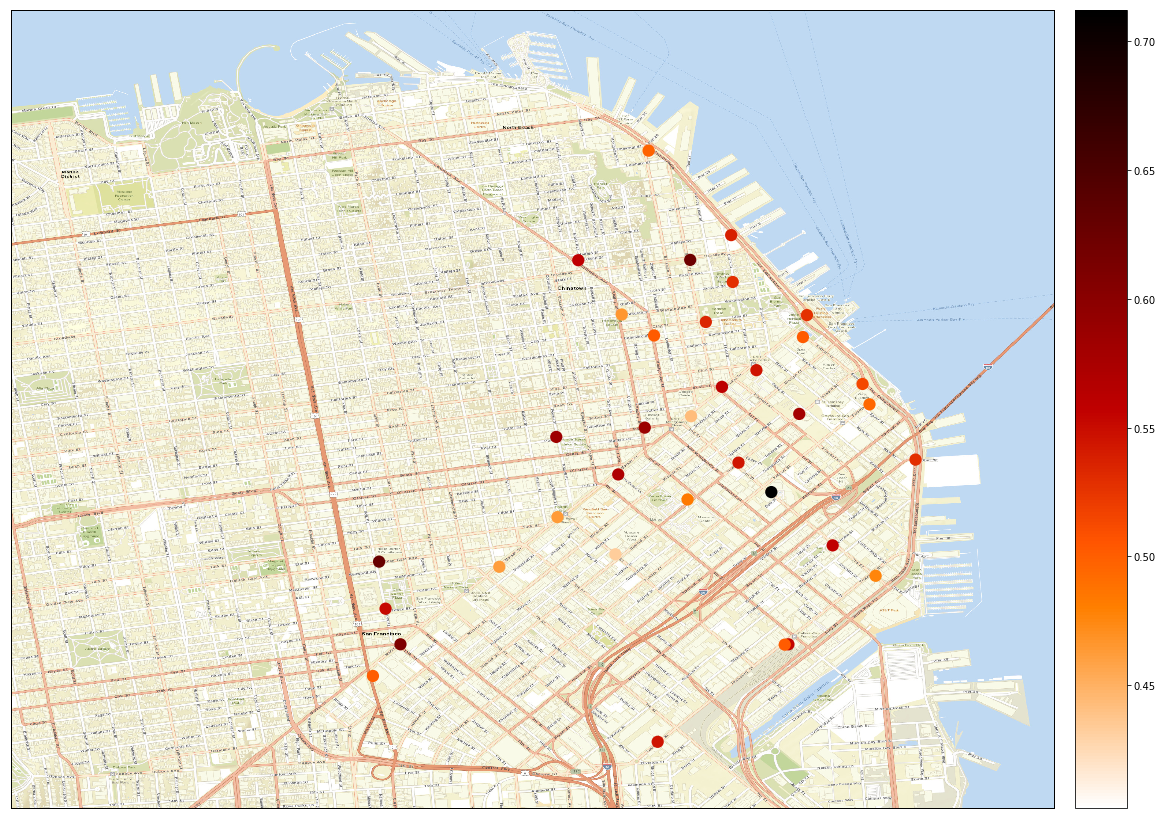

In [179]:
#view heatmap
#bbox format: (llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat)
sf_bbox = (-122.557901,37.748179,-122.32863,37.818884)
big_bbox = (-122.518954,37.229732,-121.777349,37.90477)
zoomed_bbox = (-122.439612,37.767266,-122.380133,37.812801)
fig_kwargs={'figsize':[20,20]}
bmap_kwargs={'epsg':'26943','resolution':'f'}
scatterplot_kwargs={'cmap':'gist_heat_r','s':150,'edgecolor':'none'}
hexbinplot_kwargs={'cmap':'gist_heat_r','gridsize':80,'edgecolor':'none'}
cbar_kwargs={}

plotHeatmap(week0, zoomed_bbox, plot_type='scatter', fig_kwargs=fig_kwargs,
            bmap_kwargs={'resolution':'f'},
            plot_kwargs=scatterplot_kwargs)
plt.show()

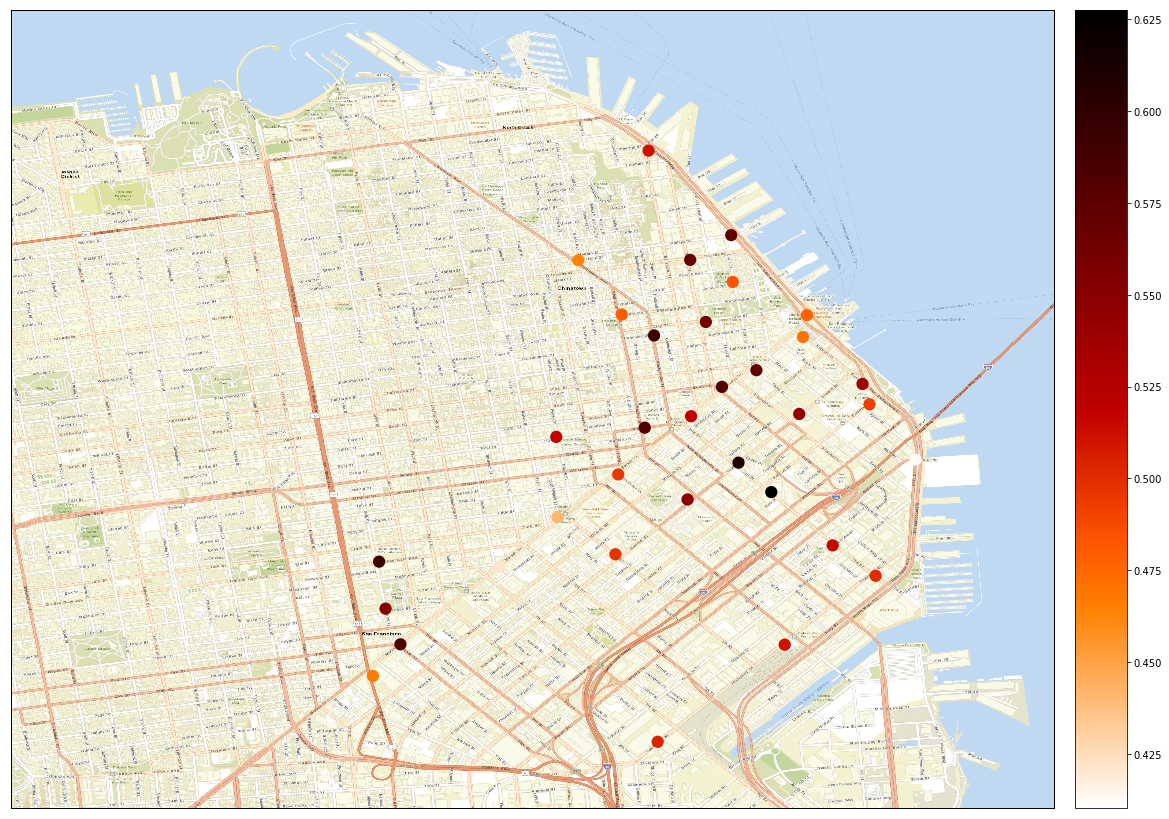

In [180]:
plotHeatmap(weekend0, zoomed_bbox, plot_type='scatter', fig_kwargs=fig_kwargs,
            bmap_kwargs={'resolution':'f'},
            plot_kwargs=scatterplot_kwargs)
plt.show()

In [128]:
df.head()

station_id time_of_day is_weekday  avg(bike_util)  id           city  \
0          33           3          0        0.470847  33  Mountain View   
1          54           1          0        0.573437  54  San Francisco   
2          64           1          0        0.483741  64  San Francisco   
3           4           0          0        0.510602   4       San Jose   
4          33           0          0        0.472144  33  Mountain View   

         lat        long  
0  37.400241 -122.099076  
1  37.787152 -122.388013  
2  37.782259 -122.392738  
3  37.333988 -121.894902  
4  37.400241 -122.099076

In [145]:
clusterdf = pd.read_csv('Data/station_cluster.csv')
clusterdf.rename(columns={'station': 'station_id'}, inplace = True)
finaldf = df.merge(clusterdf, on = 'station_id')
finaldf = finaldf[['station_id', 'lat', 'long', 'cluster']].drop_duplicates()

station_id  cluster
0           2        2
1           3        0
2           4        2
3           5        2
4           6        2

In [190]:
def plotClusters(df,bbox,fig_kwargs,bmap_kwargs,plot_kwargs):
    fig, ax = plt.subplots(**fig_kwargs)
    bmap = Basemap(bbox[0], bbox[1], bbox[2], bbox[3], ax=ax, **bmap_kwargs)
#     bmap.drawcoastlines()
    bmap.drawmapboundary()
    bmap.arcgisimage(service = 'World_Street_Map', xpixels = 1000, verbose = False)
    x, y = bmap(df['long'].values, df['lat'].values)
    plot = bmap.scatter(x, y, c = df['cluster'].values,**plot_kwargs)
    bmap.colorbar(plot, **cbar_kwargs)
    return bmap, fig, ax

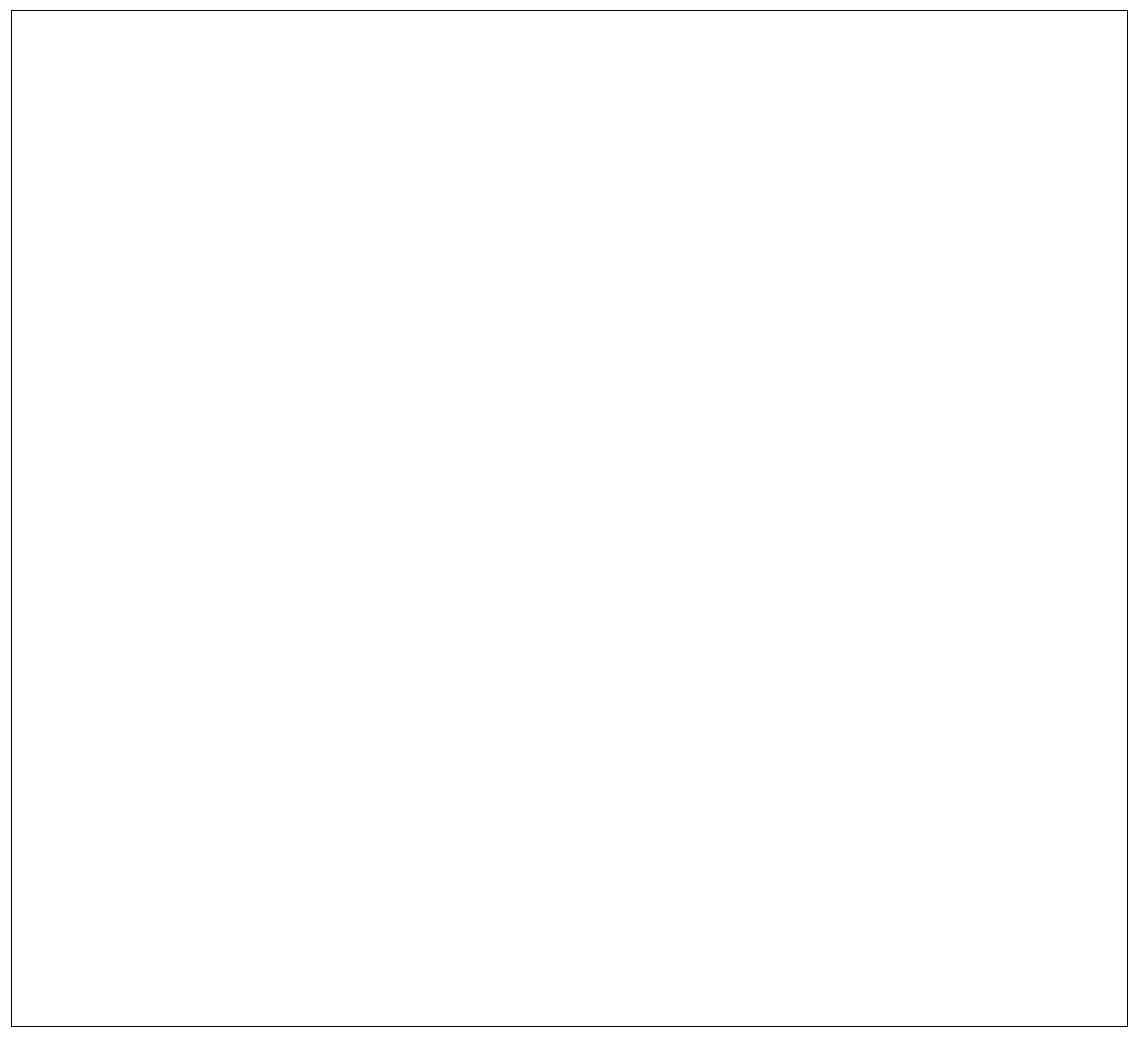

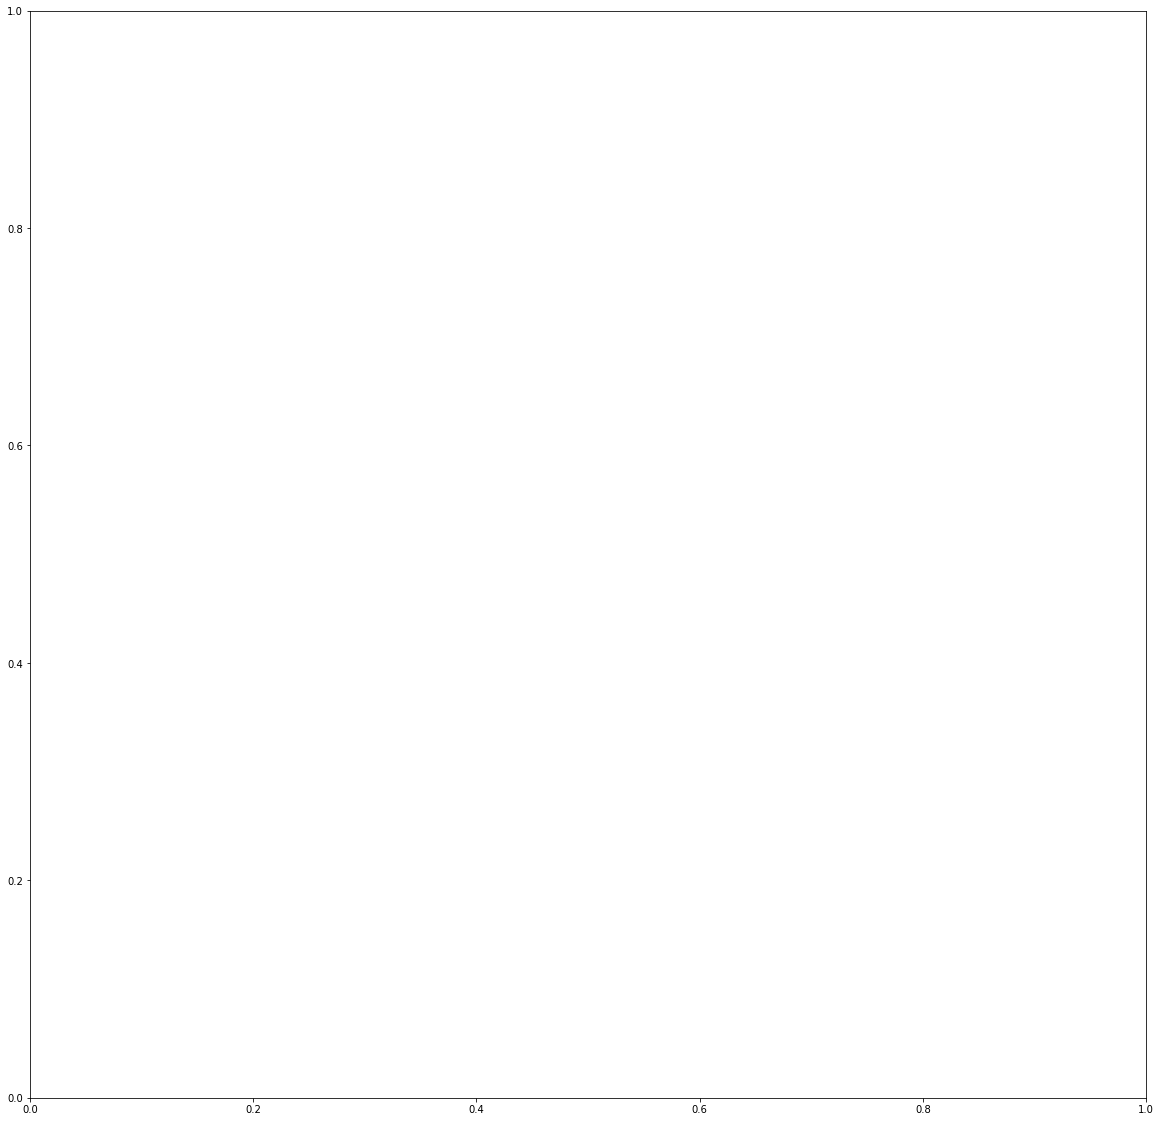

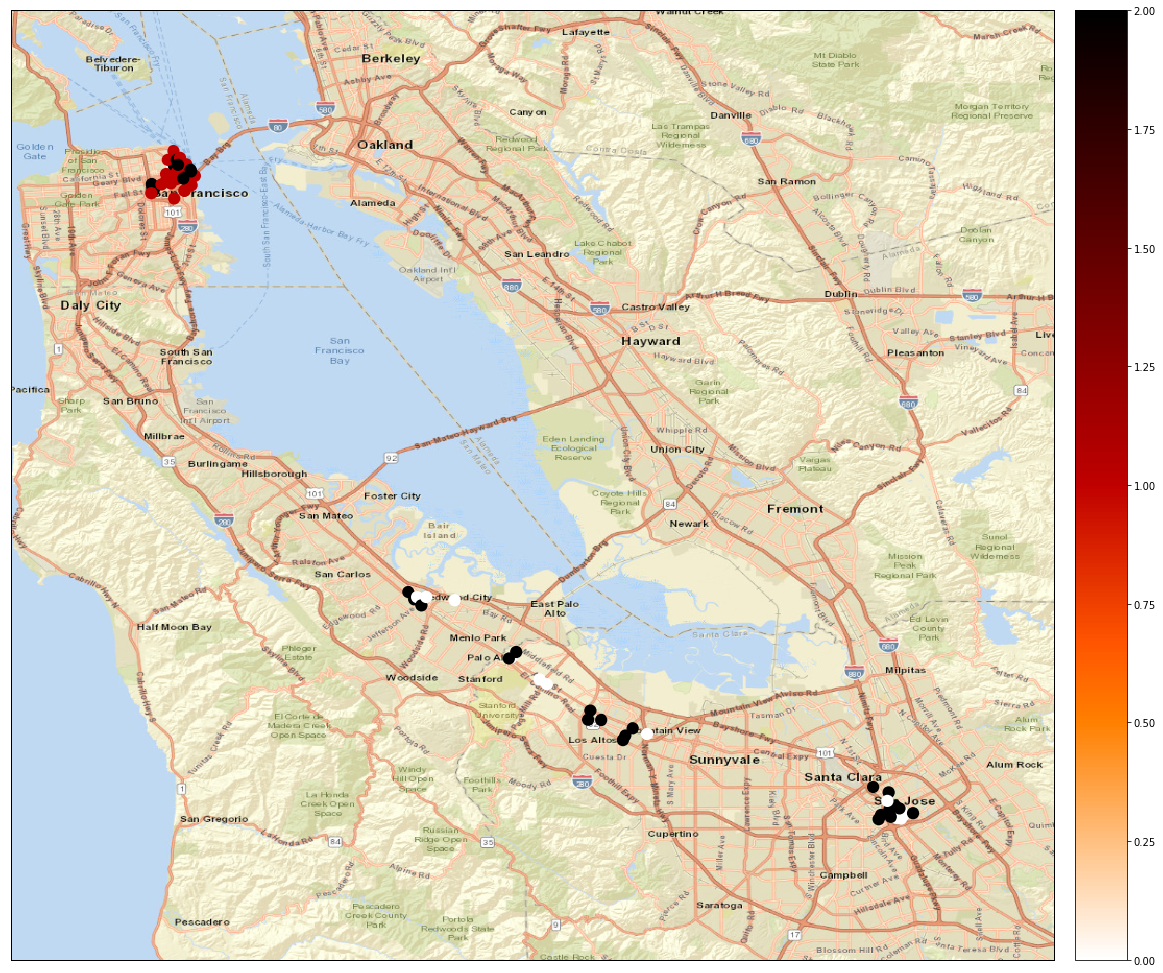

In [191]:
plotClusters(finaldf, big_bbox, fig_kwargs=fig_kwargs,
            bmap_kwargs={'resolution':'h'},
            plot_kwargs=scatterplot_kwargs)
plt.legend(loc='lower right')
plt.show()

In [ ]:
def plotClusters(df,bbox,fig_kwargs,bmap_kwargs,plot_kwargs):
    fig, ax = plt.subplots(**fig_kwargs)
    bmap = Basemap(bbox[0], bbox[1], bbox[2], bbox[3], ax=ax, **bmap_kwargs)
#     bmap.drawcoastlines()
    bmap.drawmapboundary()
    bmap.arcgisimage(service = 'World_Street_Map', xpixels = 1000, verbose = False)
    x, y = bmap( s)
    plot = bmap.scatter(df['long'].values,df['lat'].values, c = df['cluster'].values,**plot_kwargs)
    bmap.colorbar(plot, **cbar_kwargs)
    return bmap, fig, ax